In [1]:
# 1. Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np # Import pour l'alias 'np'
import matplotlib.pyplot as plt # Import pour plt.figure, plt.show, etc.
import seaborn as sns          # Import pour sns.barplot



# 2. Chargement des données (assurez-vous que le chemin est correct)
df = pd.read_csv('simulated_email_data_bilingual.csv')

# 3. Création des caractéristiques numériques à partir du temps et de la longueur
df['hour'] = df['send_time'].apply(lambda x: int(x.split(':')[0]))
df['body_length'] = df['body'].apply(len)

# 4. Séparation des caractéristiques (X) et de la cible (y)
# Nous sélectionnons les caractéristiques CLASSIQUES pour ce module
X = df[['sender_domain', 'sender_role', 'hour', 'has_attachment', 'body_length']]
y = df['label']

# 5. Séparation des ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 
# 'stratify=y' est VITAL pour garantir la même proportion de BEC (9.1%) dans les deux ensembles.

print("Taille de l'ensemble d'entraînement :", X_train.shape)
print("Taille de l'ensemble de test :", X_test.shape)

Taille de l'ensemble d'entraînement : (1760, 5)
Taille de l'ensemble de test : (440, 5)


In [2]:
# 6. Définition du préprocesseur
# OneHotEncoder convertit les variables textuelles en colonnes binaires (0 ou 1)
categorical_features = ['sender_domain', 'sender_role']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Garde les colonnes numériques (hour, length, etc.)
)

# 7. Application du préprocesseur
# Nous entraînons l'encodeur sur les données d'entraînement, puis nous le transformons
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

--- Rapport de Classification du Module Métadonnées ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00        40

    accuracy                           1.00       440
   macro avg       1.00      1.00      1.00       440
weighted avg       1.00      1.00      1.00       440



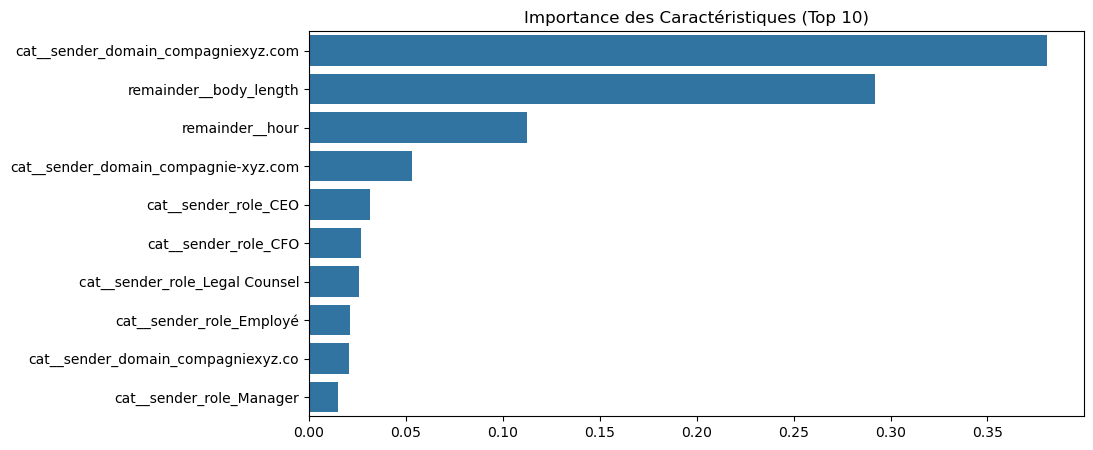

In [3]:
# 8. Initialisation et entraînement du modèle (Random Forest)
model_metadata = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
# 'class_weight="balanced"' est IMPORTANT pour compenser le déséquilibre 90/10

model_metadata.fit(X_train_processed, y_train)

# 9. Prédiction sur l'ensemble de test
y_pred = model_metadata.predict(X_test_processed)

# 10. Évaluation des Performances (Le F1-score est notre métrique principale)
print("--- Rapport de Classification du Module Métadonnées ---")
print(classification_report(y_test, y_pred))

# 11. Affichage de l'importance des caractéristiques (pour l'expliquabilité)
feature_names = preprocessor.get_feature_names_out()
importances = model_metadata.feature_importances_

# Triage et affichage des 10 caractéristiques les plus importantes
sorted_indices = np.argsort(importances)[::-1][:10]
plt.figure(figsize=(10, 5))
plt.title("Importance des Caractéristiques (Top 10)")
sns.barplot(x=importances[sorted_indices], y=feature_names[sorted_indices])
plt.show()

In [4]:
import joblib

# 1. Sauvegarde du modèle Random Forest
# (Assurez-vous que le modèle s'appelle bien model_metadata dans la cellule d'entraînement)
joblib.dump(model_metadata, 'metadata_model.joblib')

# 2. Sauvegarde du pré-processeur
# CORRECTION : Utilisation de la variable 'preprocessor' telle que définie dans votre code
joblib.dump(preprocessor, 'metadata_preprocessor.joblib')

print("Sauvegarde des composants du Module Métadonnées terminée : metadata_model.joblib et metadata_preprocessor.joblib")

Sauvegarde des composants du Module Métadonnées terminée : metadata_model.joblib et metadata_preprocessor.joblib
